In [20]:
#importing the libraries
%tensorflow_version 2.x
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
%matplotlib inline

In [21]:
#entering the coin code and loading the data as per input
##United States Dollars(USD) is used as the exchange rate and stored the real time data into a pandas data-frame. 
coin=input("Enter a coin code:")
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
if(coin=='BTC'):
    res = requests.get(endpoint + '?fsym=BTC&tsym=USD&limit=500')
    data=json.loads(res.content)['Data']
elif(coin=='ETH'):
    res = requests.get(endpoint + '?fsym=ETH&tsym=USD&limit=500')
    data=json.loads(res.content)['Data']
elif(coin=='XRP'):
    res = requests.get(endpoint + '?fsym=XRP&tsym=USD&limit=500')
    data=json.loads(res.content)['Data']
elif(coin=='ADA'):
    res = requests.get(endpoint + '?fsym=ADA&tsym=USD&limit=500')
    data=json.loads(res.content)['Data']
elif(coin=='VET'):
    res = requests.get(endpoint + '?fsym=VET&tsym=USD&limit=500')
    data=json.loads(res.content)['Data'] 
elif(coin=='BNB'):
    res = requests.get(endpoint + '?fsym=BNB&tsym=USD&limit=500')
    data=json.loads(res.content)['Data'] 
else:
    print("Enter any of these coins(Bitcoin[BTC]/Ethereum[ETH]/Ripple[XRP]/Cardano[ADA]/VeChain[VET]/Binance Coin[BNB]")
    input("Enter a coin code:")

Enter a coin code:BTC


In [22]:
#The currency is converted to INR 
#to_datetime() method is used to convert string Date time into Python Date time object. This is necessary as Date time objects in the file are read as a string object.
for element in data:
  element.pop('conversionType',None)
  element.pop('conversionSymbol',None)
hist = pd.DataFrame(data)
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')
hist["high"]=hist["high"]*74.32
hist["low"]=hist["low"]*74.32
hist["open"]=hist["open"]*74.32
hist["close"]=hist["close"]*74.32
pd.options.display.float_format = '{:.6f}'.format
pd.options.display.float_format = '{:.6f}'.format
target_col = 'close'

In [23]:
#to see how the dataset looks like with all the features like price, volume etc
#"Volume From" is the number of Bitcoins traded for INR while "Volume To" is the number of Rupees traded (for the period) for Bitcoins.
hist.tail(5)

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2021-11-08,5035585.787200,4704662.609600,4704662.609600,39774.170000,2614939972.010000,5020252.084800
2021-11-09,5091979.803200,4928339.054400,5020252.084800,32745.530000,2209551778.820000,4974924.316800
2021-11-10,5126492.524800,4696745.300000,4974924.316800,50591.310000,3365466815.360000,4825304.779200
2021-11-11,4874327.737600,4766169.098400,4825304.779200,21475.670000,1393819061.450000,4817481.856000
2021-11-12,4865433.120000,4765550.756000,4817481.856000,6164.840000,399791299.870000,4801647.236800


In [24]:
#splitting the dataset into training and testing set with 80% and 20% data respectively
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [25]:
train, test = train_test_split(hist, test_size=0.2)

In [26]:
#plotting the cryptocurrency prices in INR as a function of time
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [INR]]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

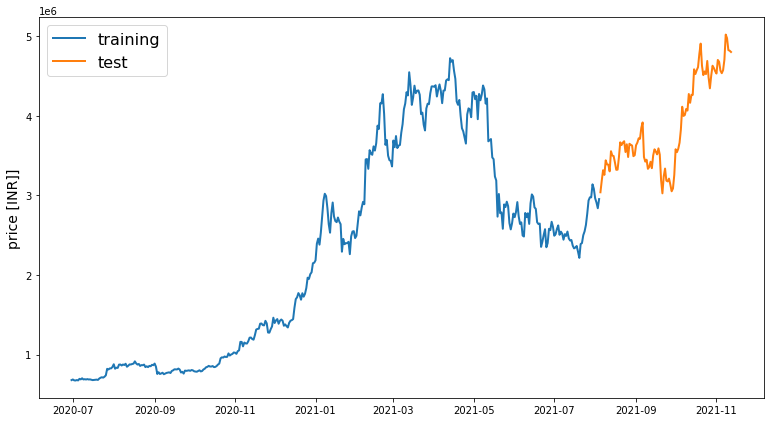

In [27]:
line_plot(train[target_col], test[target_col], 'training', 'test', title='')

In [28]:
#normalizing the values
#Normalization is a technique often applied as part of data preparation for machine learning. 
#The goal of normalization is to change the values of numeric columns in the dataset to a common scale, without distorting differences in the ranges of values.
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [29]:
#extract data of windows which are of size 5 each
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [30]:
#function to prepare the data in a format to be later fed into the neural network.
#splitting the data into two sets — training set and test set with 80% and 20% data
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):

    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [31]:
#Sequential model is used for stacking all the layers (input, hidden and output). 
#The neural network comprises of a LSTM layer followed by 20% Dropout layer and a Dense layer with linear activation function.
#build the model using Adam as the optimizer and Mean Squared Error as the loss function.
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [32]:
#set up some of the parameters to be used later
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [33]:
train, test, X_train, X_test, y_train, y_test = prepare_data(hist,target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [34]:
#train the model using inputs x_train and labels y_train.
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/20
13/13 [==============================] - 3s 54ms/step - loss: 0.0096 - val_loss: 0.0034
Epoch 2/20
13/13 [==============================] - 0s 8ms/step - loss: 0.0050 - val_loss: 0.0025
Epoch 3/20
13/13 [==============================] - 0s 10ms/step - loss: 0.0040 - val_loss: 0.0023
Epoch 4/20
13/13 [==============================] - 0s 8ms/step - loss: 0.0037 - val_loss: 0.0023
Epoch 5/20
13/13 [==============================] - 0s 9ms/step - loss: 0.0035 - val_loss: 0.0022
Epoch 6/20
13/13 [==============================] - 0s 8ms/step - loss: 0.0033 - val_loss: 0.0020
Epoch 7/20
13/13 [==============================] - 0s 8ms/step - loss: 0.0033 - val_loss: 0.0021
Epoch 8/20
13/13 [==============================] - 0s 10ms/step - loss: 0.0033 - val_loss: 0.0021
Epoch 9/20
13/13 [==============================] - 0s 8ms/step - loss: 0.0031 - val_loss: 0.0019
Epoch 10/20
13/13 [==============================] - 0s 8ms/step - loss: 0.0027 - val_loss: 0.0019
Epoch 11/20
13/1

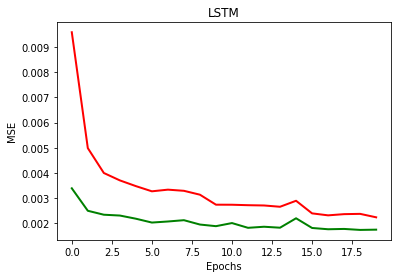

In [35]:
#plot the graph of epochs vs MSE
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],'r',linewidth=2, label='Train loss')
plt.plot(history.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('LSTM')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

In [36]:
#MAE measures the average magnitude of the errors in a set of predictions, without considering their direction. 
#It’s the average over the test sample of the absolute differences between actual and predicted observations where all individual differences have equal weight.
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

0.03171609677165421

In [37]:
#measures the average of error squares i.e. the average squared difference between the estimated values and true value
from sklearn.metrics import mean_squared_error
MAE=mean_squared_error(preds, y_test)
MAE

0.0017458194614383329

In [38]:
#regression score function.
#Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse)
from sklearn.metrics import r2_score
R2=r2_score(y_test, preds)
R2

0.6391481838977627

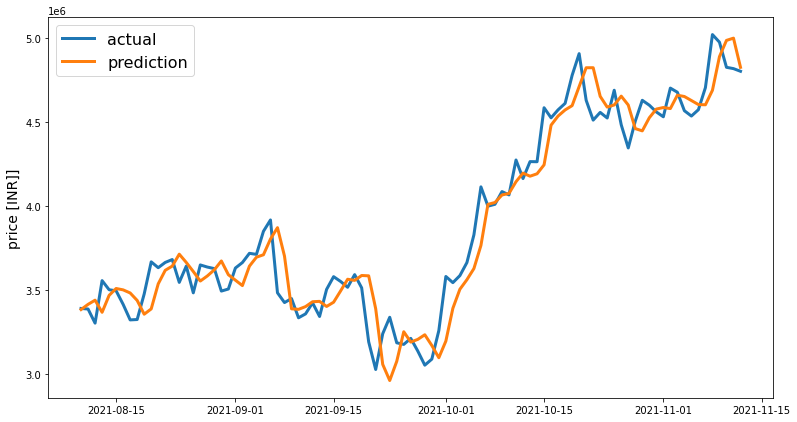

In [39]:
#plot the actual and predicted prices
preds = test[target_col].values[:-window_len] * (preds+1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)